In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob

In [2]:
import sys

In [3]:
sys.path

['/Users/verakocetkova/Desktop/Data Science/ComputerVision/notebooks',
 '/Users/verakocetkova/.conda/envs/ComputerVision/lib/python310.zip',
 '/Users/verakocetkova/.conda/envs/ComputerVision/lib/python3.10',
 '/Users/verakocetkova/.conda/envs/ComputerVision/lib/python3.10/lib-dynload',
 '',
 '/Users/verakocetkova/.conda/envs/ComputerVision/lib/python3.10/site-packages']

In [4]:
sys.path.append('../')

## find corners in chessboard

In [5]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((7*7,3), np.float32)

objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

In [6]:
images = glob.glob("../images_camera/*.jpeg")

In [7]:
images

['../images_camera/1DEC4A0D-A317-4321-9539-FD76924B6908_1_105_c.jpeg',
 '../images_camera/BCDA1735-396F-4CF4-9DD8-52C42452C1BC_1_105_c.jpeg',
 '../images_camera/5B6CE418-63DC-4A8B-B9BB-660F9ECA63F7_1_105_c.jpeg',
 '../images_camera/B50750FC-CBB9-4F06-B1CC-BA8D3FF52E7F_1_105_c.jpeg',
 '../images_camera/FA6EE765-380E-4866-889A-500EFA0A8412_1_105_c.jpeg',
 '../images_camera/80604FD2-022A-4088-9EB6-02E553A01C99_1_105_c.jpeg',
 '../images_camera/C7663365-53CE-49A5-A211-A1159971DB60_1_105_c.jpeg',
 '../images_camera/FAE1622C-97BD-421C-A5C3-9634AA3195F5_1_105_c.jpeg',
 '../images_camera/5C329AF8-CC3B-4590-A59E-7B36F3C05862_1_105_c.jpeg',
 '../images_camera/40C92F85-DC45-4ED5-80DA-30DA25E897FC_1_105_c.jpeg',
 '../images_camera/D0EC4A46-3ECA-4F84-972F-5989CF6A43AB_1_105_c.jpeg']

In [8]:
objpoints = []
imgpoints = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,7), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,7), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

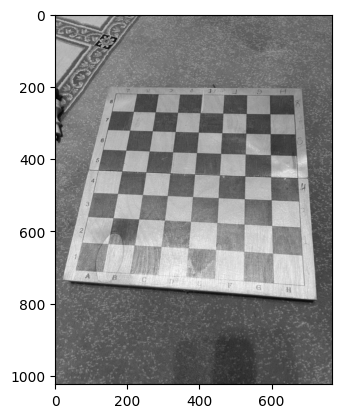

In [9]:
plt.imshow(gray, "gray");

## calibration

In [10]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [11]:
mtx

array([[737.62661996,   0.        , 380.37567845],
       [  0.        , 859.46518567, 727.78254896],
       [  0.        ,   0.        ,   1.        ]])

## undistored

In [12]:
def check_result(objpoints, imgpoints, mtx, dist, rvecs, tvecs):
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print( "total error: {}".format(mean_error/len(objpoints)) )

receive new matrix with calibration

In [13]:
img = cv2.imread('../images_camera/1DEC4A0D-A317-4321-9539-FD76924B6908_1_105_c.jpeg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))


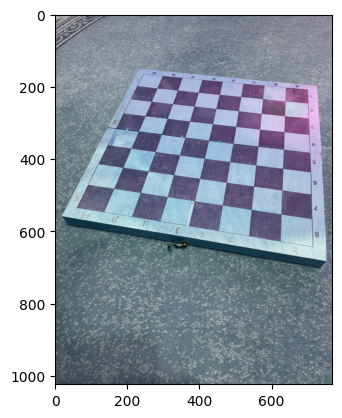

In [14]:
plt.imshow(img, "gray")

let's try method Undistort to fix the photo

In [15]:
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('../images_camera/calibresult.png', dst)


True

In [16]:
check_result(objpoints, imgpoints, mtx, dist, rvecs, tvecs)

total error: 0.07544082684124963


In [17]:
new_img = cv2.imread('../images_camera/calibresult.png')

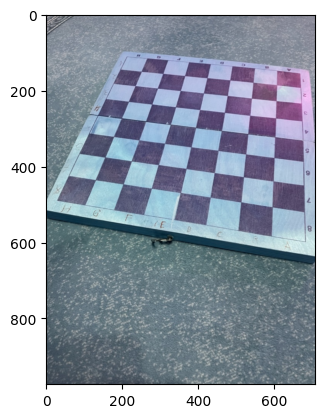

In [18]:
plt.imshow(new_img, "gray");

Here let's try another method

In [19]:
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('../images_camera/calibresult_2.png', dst)


True

In [20]:
check_result(objpoints, imgpoints, mtx, dist, rvecs, tvecs)

total error: 0.07544082684124963


In [21]:
new_img_2 = cv2.imread('../images_camera/calibresult_2.png')

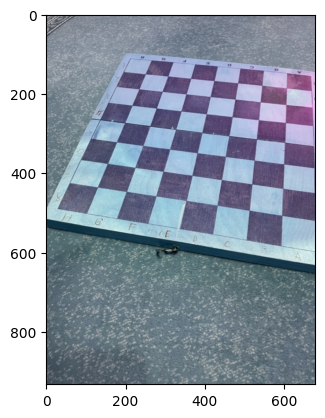

In [22]:
plt.imshow(new_img_2, "gray");

errors are very similar

## Pose estimation

In [23]:
def draw(img, corners, imgpts):
    corner = tuple(map(int, corners[0].ravel()))
    colors = [(255,0,0), (0,255,0), (0,0,255)]
    for i in range(len(imgpts)):
        points2 = tuple(map(int, imgpts[i].ravel()))
        img = cv2.line(img, corner, points2, colors[i], 5)
    return img

In [25]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)


In [26]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,7),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img,corners2,imgpts)
        cv2.imshow('img',img)
        k = cv2.waitKey(500)# & 0xFF
#         if k == ord('s'):
#             cv2.imwrite(fname[:6]+'.png', img)
cv2.destroyAllWindows()

it worked!

second method

In [27]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    print(imgpts)
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

In [29]:
axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

In [30]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,7),None)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img,corners2,imgpts)
        cv2.imshow('img',img)
        k = cv2.waitKey(500)# & 0xFF
#         if k == ord('s'):
#             cv2.imwrite(fname[:6]+'.png', img)
cv2.destroyAllWindows()

[[ 283  205]
 [ 231  325]
 [ 425  349]
 [ 455  223]
 [ 241 -117]
 [ 174   38]
 [ 432   70]
 [ 473  -91]]


Looks good